<a href="https://colab.research.google.com/github/mphop7/snack_health_rating/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!rm -r augmented_dataset
# to delete aug. dataset before re-running code

#Imports

In [2]:
import os
import random
from PIL import Image, ImageEnhance, ImageFilter
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

#Augmentation function

In [3]:
def augment_image(img):
    if random.random() < 0.3:
        img = img.rotate(random.randint(-10, 10))
    if random.random() < 0.3:
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(random.uniform(0.9, 1.1))
    if random.random() < 0.3:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.9, 1.1))
    if random.random() < 0.3:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(0.9, 1.1))
    if random.random() < 0.1:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.2, 0.5)))
    return img

#Apply and save augmentations

In [4]:
source_dir = "walkers_dataset"
augmented_dir = "augmented_dataset"
max_variants = 50
os.makedirs(augmented_dir, exist_ok=True)

for label in ["walkers", "not_walkers"]:
    src_class_dir = os.path.join(source_dir, label)
    dst_class_dir = os.path.join(augmented_dir, label)
    os.makedirs(dst_class_dir, exist_ok=True)
    for fname in os.listdir(src_class_dir):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(src_class_dir, fname)
        img = Image.open(img_path).convert('RGB')
        base_name, ext = os.path.splitext(fname)
        for i in range(max_variants):
            aug_img = augment_image(img)
            aug_name = f"{base_name}_aug{i+1}{ext}"
            aug_img.save(os.path.join(dst_class_dir, aug_name))

#Custom dataset

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.augment:
            img = augment_image(img)

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.augment:
            img = augment_image(img)

        if self.transform:
            img = self.transform(img)

        return img, label

#Data loading

In [7]:
base_dir = "walkers_dataset"
classes = ["not_walkers", "walkers"]

image_paths = []
labels = []
for idx, cls in enumerate(classes):
    cls_dir = os.path.join(base_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(cls_dir, fname))
            labels.append(idx)

# Transformations, datasets and dataloaders

In [8]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Train class distribution:", Counter(train_labels))
print("Validation class distribution:", Counter(val_labels))

Train class distribution: Counter({1: 32, 0: 32})
Validation class distribution: Counter({0: 8, 1: 8})


In [9]:
to_tensor_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(train_paths, train_labels, transform=to_tensor_transform, augment=True)
val_dataset = CustomImageDataset(val_paths, val_labels, transform=to_tensor_transform, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [10]:
# from collections import Counter

# # Check training labels
# train_labels = [label for _, label in train_loader.dataset]
# print("Train class distribution:", Counter(train_labels))

# # Check validation labels
# val_labels = [label for _, label in val_loader.dataset]
# print("Validation class distribution:", Counter(val_labels))


#Show some sample images

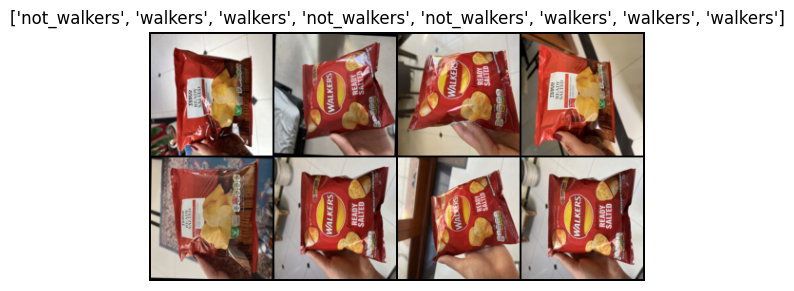

In [13]:
import torchvision

def imshow(img, title=None):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8], nrow=4), title=[classes[label] for label in labels[:8]])

#Definition of CNN model

In [14]:
class LogoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#Training and validation

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogoClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * train_correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%")

Epoch 1 | Train Loss: 6.038 | Train Acc: 46.88% | Val Loss: 0.806 | Val Acc: 50.00%
Epoch 2 | Train Loss: 2.594 | Train Acc: 60.94% | Val Loss: 0.601 | Val Acc: 50.00%
Epoch 3 | Train Loss: 1.975 | Train Acc: 79.69% | Val Loss: 0.418 | Val Acc: 93.75%
Epoch 4 | Train Loss: 1.299 | Train Acc: 100.00% | Val Loss: 0.260 | Val Acc: 93.75%
Epoch 5 | Train Loss: 0.632 | Train Acc: 96.88% | Val Loss: 0.148 | Val Acc: 93.75%


#Evaluation

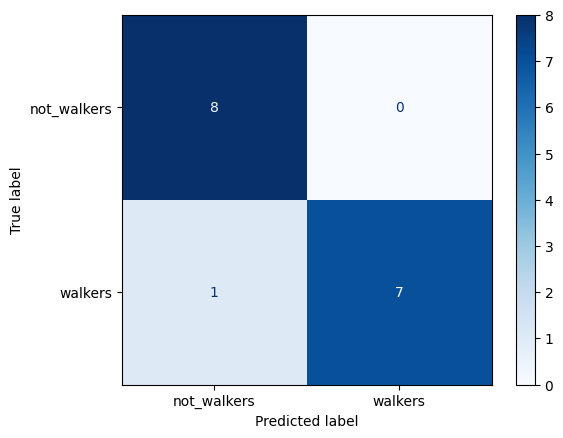

              precision    recall  f1-score   support

 not_walkers       0.89      1.00      0.94         8
     walkers       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



In [16]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels)

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))

In [17]:
# print("Total images loaded:", len(full_dataset))

In [18]:
# from collections import Counter
# labels = [label for _, label in full_dataset]
# print(Counter(labels))

i want to reduce the severity of the augmentations and